In [14]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import json 
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
from numba import cuda
from peft import LoraConfig
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding

In [2]:
try:
    connection = pymysql.connect(
        host=,
        port=,
        user='communav',
        password='',
        database='communav'
    )
    print('Successfully connected to DB.')
except:
    print(f'Failed to connect to DB. ')

Successfully connected to DB.


In [3]:
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        labels.category_ids
    FROM everytime_original_articles articles
    JOIN everytime_article_labels labels ON articles.id = labels.article_id
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')
print(original_articles)

cursor.close()
connection.close()

Loaded 2393 articles.
((100245988, '장학금 관련해서..', '성적장학금 + 한울장학금 가능한지 궁금합니다..', '[1, 3]'), (100634300, '배고파 집에가서', '진짬뽕에 밥 말아먹어야지 히힣', '[]'), (100656956, '부산 + 용인까지 의심 환자 발생', '평택시는 난리남.\n부산에서도..\n근데 이상한건 용인인데.\n그 분은 중국 갔다온사람 아니라던데?\n뭐냐 진짜..', '[]'), (100682214, '신종 코로나바이러스(2019-nCoV) 감염증 대처 방법', "원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.\n \n==========================================\n최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다. \n여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다. \n \n저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.\n \n개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 분들께서는 대부분 현장에서 나가 계셔서 저처럼 자리에 앉아 있으실 수 없을듯 합니다. \n \n 1. 신종 코로나 바이러스 감염증에 대해서 궁금하신 것이 있으시면 무엇이든 질문해주세요. 적극적으로 정보를 

In [4]:
# 전처리
datasets = []
original_articles = pd.DataFrame(original_articles)
original_articles.columns = ['id' , 'title', 'text', 'category_ids']
for i in range(12):
    if i == 0: continue
    datasets.append(pd.DataFrame([(article['title'] + article['text'] , 1) if i in list(json.loads(article['category_ids'])) else (article['title'] + article['text'] , 0) for k, article in original_articles.iterrows()] ))
    datasets[i - 1].columns = ['content', 'label']
for i in range(11):
    true_label = [(data.content, data.label) for data in datasets[i].itertuples() if data.label == 1]
    false_label = [(data.content, data.label) for data in datasets[i].itertuples() if data.label == 0]
    false_label = false_label[:len(true_label) * 2]
    true_label.extend(false_label)
    datasets[i] = pd.DataFrame(true_label, columns=['content', 'label'])

In [5]:
def plot_distribution(articles):
    label_counts = [0, 0]
    for article in articles.itertuples():
        label_counts[article.label] += 1

    total_count = sum(label_counts)
    percentages = [count / total_count * 100 for count in label_counts]
    for i, percentage in enumerate(percentages):
        print(f'Label {i}: {percentage:.2f}%')

    plt.figure(figsize=(8, 6))
    plt.bar(['0', '1'], label_counts)
    plt.text(0, label_counts[0] + 0.1, str(label_counts[0]), ha='center')
    plt.text(1, label_counts[1] + 0.1, str(label_counts[1]), ha='center')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

Label 0: 66.67%
Label 1: 33.33%


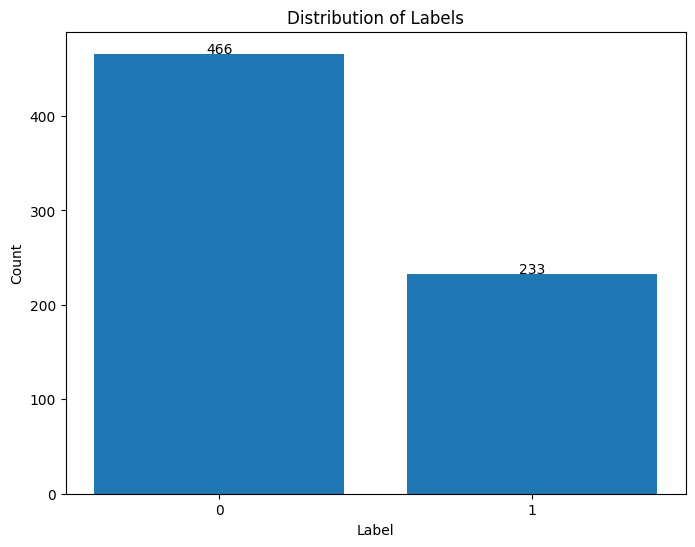

In [6]:
# datasets[1].columns = ['content', 'label']
# df = pd.DataFrame(datasets[1], columns=['content', 'label'])
plot_distribution(datasets[1])

In [7]:
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
MAX_LENGTH = 128
F_BETA = 0.5
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 2e-5
SAVE_PATH = r"./"

In [8]:
# 각 라벨링 별 train, test set 생성
train_val_sets = []
for i in range(11):
    train_articles, val_articles = train_test_split( datasets[i], test_size=0.2, random_state=42 )
    train_val_sets.append((train_articles, val_articles))

In [9]:
def make_dataset(category_id):
    train_articles, val_articles = train_val_sets[category_id]
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # train_articles = train_articles[:len(val_articles)]
    train_contents = [article.content for article in train_articles.itertuples()]
    train_labels = [article.label for article in train_articles.itertuples()]
    val_contents = [article.content for article in val_articles.itertuples()]
    val_labels = [article.label for article in val_articles.itertuples()]

    class CustomDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_encodings = tokenizer(
        train_contents,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=MAX_LENGTH
    )
    val_encodings = tokenizer(
        val_contents,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=MAX_LENGTH
    )

    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset = CustomDataset(val_encodings, val_labels)
    # train_dataset = torch.utils.data.TensorDataset(
        # train_encodings['input_ids'],
        # train_encodings['attention_mask'],
        # torch.tensor(train_labels)
    # )
    # val_dataset = torch.utils.data.TensorDataset(
        # val_encodings['input_ids'],
        # val_encodings['attention_mask'],
        # torch.tensor(val_labels)
    # )

    # train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataset, val_dataset, data_collator, tokenizer

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, fbeta, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'fbeta': fbeta,
    }

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050


In [12]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
model.to(device)

# 모든 파라미터를 고정
for param in model.parameters():
    param.requires_grad = False

# 마지막 레이어의 파라미터만 학습 가능하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model's state_dict:
electra.embeddings.word_embeddings.weight 	 torch.Size([54343, 768])
electra.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
electra.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
electra.embeddings.LayerNorm.weight 	 torch.Size([768])
electra.embeddings.LayerNorm.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size(

In [13]:
metrics_rst = []

target_modules = "query,value,output.dense,intermediate.dense,classifier.dense,classifier.out_proj".split(",")
lora_config = LoraConfig(
        r=16,  # 업데이트 행렬의 순위로, 정수로 표현됩니다. 낮은 순위는 더 적은 학습 가능한 파라미터를 가진 작은 업데이트 행렬을 생성합니다.
        lora_alpha=32,  # LoRA 스케일링 팩터입니다.
        target_modules=target_modules,
        lora_dropout=0.05,  
        bias="none", 
        task_type="CAUSAL_LM" 
        )


for id in range(1, 11):
    train_datasets, val_datasets, data_collator, tokenizer = make_dataset(id)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
    # model.to(device)
    model_path = SAVE_PATH + f'model-with-LoRA-category-id-' + str(id) + '-LoRA-adaptors'

    # model = prepare_model_for_kbit_training(model)
 
    # add LoRA adaptor
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    # Define training args
    training_args = TrainingArguments(
        output_dir=SAVE_PATH,
    	per_device_train_batch_size=16,  # 훈련 배치 크기
        per_device_eval_batch_size=16,
        learning_rate=LEARNING_RATE, # higher learning rate
        num_train_epochs=100,
        logging_dir=f"{SAVE_PATH}/logs",
        logging_strategy="steps",
        logging_steps=50,
        save_strategy="no",
        report_to="tensorboard",
        )
 
    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_datasets,
        eval_dataset=val_datasets,
        data_collator = data_collator,
        compute_metrics=compute_metrics,
        )
    
    trainer.train()
    lora_weights = {name: param for name, param in model.named_parameters() if 'lora' in name}
    torch.save(lora_weights, model_path)

    # torch.save(model.lora.state_dict(), model_path)

        
print('Training finished.')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


C:\Users\USER\AppData\Local\Temp\ipykernel_15200\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
50,0.679800
100,0.645200
150,0.625000
200,0.618700
250,0.617300
300,0.605500
350,0.590800
400,0.563100
450,0.541300
500,0.515900


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.690100
100,0.640000
150,0.615800
200,0.589600
250,0.562700
300,0.481200
350,0.340900
400,0.236700
450,0.161400
500,0.098800


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.689700
100,0.636400
150,0.610600
200,0.602200
250,0.591200
300,0.587500
350,0.573300
400,0.580500
450,0.565400
500,0.543400


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.690000
100,0.656800
150,0.623000
200,0.609300
250,0.569900
300,0.534500
350,0.453000
400,0.391800
450,0.349900
500,0.294700


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.689200
100,0.656000
150,0.628300
200,0.621200
250,0.609900
300,0.565100
350,0.526800
400,0.445100
450,0.379300
500,0.319100


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.690000
100,0.639000
150,0.614300
200,0.609400
250,0.573500
300,0.533300
350,0.419300
400,0.335100
450,0.256400
500,0.189500


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.692200
100,0.648100
150,0.642500
200,0.617200
250,0.594600
300,0.593600
350,0.569500
400,0.514700
450,0.459400
500,0.389100


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.686000
100,0.629200
150,0.594200
200,0.579700
250,0.550000
300,0.533700
350,0.447600
400,0.349400
450,0.277700
500,0.219100


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.693500
100,0.652200
150,0.619600
200,0.594100
250,0.552400
300,0.483400
350,0.377800
400,0.265600
450,0.177200
500,0.112100


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss
50,0.690000
100,0.642400
150,0.616000
200,0.627300
250,0.585400
300,0.585000
350,0.554100
400,0.480400
450,0.377900
500,0.311100


Training finished.


In [16]:
categories = ['학사/졸업' , '장학/행정', '학교생활', '수업/이과', '수업/문과' , '캠퍼스' ,'일상생활', '취미/여가', '인간관계', '취업/진로']

test_datasets = pd.DataFrame([ (article.title + article.text , article.category_ids) for article in original_articles.itertuples()], columns = ['content', 'label'])
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

target_modules = "query,value,output.dense,intermediate.dense,classifier.dense,classifier.out_proj".split(",")
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
model.to(device)
model = get_peft_model(model, lora_config)

pred_labels = []
for row in test_datasets.content.tolist()[:400]:
    tokens =tokenizer(
        row,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=MAX_LENGTH
    )    
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    pred_labels_per_row = []
    for id in range(1, 11):
        model_path = SAVE_PATH + f'model-with-LoRA-category-id-' + str(id) + '-LoRA-adaptors'
        lora_weights = torch.load(model_path)
        for name, param in model.named_parameters():
            if 'lora' in name and name in lora_weights:
                param.data = lora_weights[name]
        # model.lora.load_state_dict(torch.load(model_path))
        # last_layers_weights = torch.load(model_path)
        
        # encoder_layer_11_weights = last_layers_weights['encoder_layer_11']

        # for name, param in model.electra.encoder.layer[11].named_parameters():
             # if name in encoder_layer_11_weights:
                 # param.data = encoder_layer_11_weights[name].data

        # model.classifier.dense.load_state_dict(last_layers_weights['dense'])
        # model.classifier.out_proj.load_state_dict(last_layers_weights['out_proj'])

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_label = torch.argmax(logits, dim=1)

        if predicted_label == 1:
            pred_labels_per_row.append(categories[id - 1])
        torch.cuda.empty_cache()
    pred_labels.append(pred_labels_per_row)

for i in range(400):
    print(f'content : {test_datasets.content[i]}')
    print(f'labels : {pred_labels[i]}')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


content : 장학금 관련해서..성적장학금 + 한울장학금 가능한지 궁금합니다..
labels : ['장학/행정']
content : 배고파 집에가서진짬뽕에 밥 말아먹어야지 히힣
labels : []
content : 부산 + 용인까지 의심 환자 발생평택시는 난리남.
부산에서도..
근데 이상한건 용인인데.
그 분은 중국 갔다온사람 아니라던데?
뭐냐 진짜..
labels : []
content : 신종 코로나바이러스(2019-nCoV) 감염증 대처 방법원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.
 
최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다. 
여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다. 
 
저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.
 
개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 분들께서는 대부분 현장에서 나가 계셔서 저처럼 자리에 앉아 있으실 수 없을듯 합니다. 
 
 1. 신종 코로나 바이러스 감염증에 대해서 궁금하신 것이 있으시면 무엇이든 질문해주세요. 적극적으로 정보를 찾아서 제공해드리겠습니다. 어떠한 질문이든 관계없습니다. : 제가 2군데 사이트에서 모은 질문들을 정리해서 아래에 작성했습니다. 자유롭게 퍼가셔도 됩니다. 
 
2. 많은 

In [16]:
predictions = [
    # 질문 · 답변
    '학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?',
    '대학교 1학년 때 교양 과목으로 추천할 만한 강의가 있을까요?',
    '학교 도서관에서 책을 대출하는 방법이 궁금합니다. 알려주실 수 있나요?',
    '학교에서 운영하는 학생 지원 프로그램에는 어떤 것들이 있나요?',
    '교내 봉사활동 기회에 대해 더 자세히 알고 싶습니다. 정보를 제공해 주시겠어요?',

    # 학사 · 졸업
    '이번 학기 수강 신청 일정이 언제인가요? 강의 계획서는 어디서 확인할 수 있을까요?',
    '복수 전공 신청 자격 요건과 절차가 궁금합니다. 자세히 설명해 주실 수 있나요?',
    '졸업 논문 제출 마감일이 언제인지 확인 부탁드립니다.',
    '전공 필수 과목과 선택 과목의 차이점이 무엇인가요? 수강 계획을 위해 알려주시면 감사하겠습니다.',
    '휴학 신청 방법과 유의사항에 대해 자세히 설명해 주시겠어요?',

    # 장학 · 행정
    '교내 장학금 신청 자격과 절차에 대해 알려주세요.',
    '국가 장학금 신청 기간과 필요한 서류가 무엇인지 궁금합니다.',
    '학자금 대출 상환 방법과 유예 조건에 대해 자세히 설명해 주시겠어요?',
    '전과 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.',
    '학생증 재발급 신청은 어떻게 하나요? 수수료가 있나요?',

    # 학교생활
    '교내에서 활동 중인 동아리에는 어떤 것들이 있나요? 동아리 소개 부탁드립니다.',
    '이번 학교 축제 일정과 프로그램이 궁금합니다. 정보 좀 알려주세요.',
    '교내 체육대회 참가 신청 방법과 일정이 어떻게 되나요?',
    '학생회에서 주최하는 이벤트와 캠페인에 대한 정보를 알려주실 수 있나요?',
    '교환학생 프로그램에 대해 더 자세히 알고 싶습니다. 정보 제공 부탁드려요.',

    # 수업/이과
    '이번 학기 물리학 수업 과제 제출 마감일이 언제인가요?',
    '미적분학 수업에서 배운 개념이 잘 이해되지 않습니다. 선배님들의 조언 부탁드려요.',
    '프로그래밍 언어 수업 수강을 고민하고 있는데, 파이썬과 자바 중 어떤 것을 추천하시나요?',
    '공학수학 시험 범위가 어디까지인지 확인 부탁드립니다.',
    '생물학 실험 수업을 들으려고 하는데, 실험복은 개별적으로 준비해야 하나요?',

    # 수업/문과
    '이번 학기 문학개론 수업 필독서 목록을 공유해 주시면 감사하겠습니다.',
    '철학 수업에서 다루는 주요 사상가들에 대해 간단히 소개해 주실 수 있나요?',
    '심리학 수업 팀 프로젝트 주제 선정에 대해 조언 부탁드립니다.',
    '역사학 수업 기말 리포트 분량과 참고문헌 작성 방법이 궁금합니다.',
    '언어학 수업에서 배운 개념들을 실생활에 적용하는 방법이 있을까요?',

    # 캠퍼스
    '학교 도서관 열람실 이용 시간과 좌석 예약 방법이 궁금합니다.',
    '학교 식당 메뉴와 운영 시간을 알려주시면 감사하겠습니다.',
    '기숙사 입사 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.',
    '체력단련실 이용 방법과 운영 시간에 대해 알고 싶습니다.',
    '교내 편의점 위치와 운영 시간을 알려주시겠어요?',

    # 일상생활
    '건강한 식단 관리를 위한 식습관 개선 팁을 공유해 주시면 감사하겠습니다.',
    '효과적인 시간 관리 방법과 일정 계획 앱 추천 부탁드립니다.',
    '자취생을 위한 저렴한 식재료 구매 장소와 요리 레시피 공유해 주세요.',
    '대학생 알바 경험이 있으신 분들, 시간 관리와 스트레스 해소 팁 좀 알려주시겠어요?',
    '병역 의무 관련 정보와 군 입대 시기 선택에 대한 조언 부탁드립니다.',

    # 취미 · 여가
    '강남에 가볼 만한 맛집이나 카페 추천해 주실 수 있나요?',
    '축구 활동에 관심이 있는데, 자세한 정보 좀 알려주시겠어요?',
    '기타 배우기 좋은 온라인 강의나 교재가 있다면 추천 부탁드립니다.',
    '가까운 여행지나 나들이 장소 추천해 주시면 감사하겠습니다.',
    '사진 촬영 팁과 포토샵 강좌 정보 공유 부탁드려요.',

    # 인간관계
    '대학교 새내기로서 선배님들과 좋은 관계를 맺는 방법이 있을까요?',
    '동아리나 팀 프로젝트에서 팀원들과 갈등이 생겼을 때 해결하는 방법 좀 알려주세요.',
    '친구들과 어색해졌을 때 관계 개선을 위한 조언 부탁드립니다.',
    '선배님들께 인사나 존경을 표현하는 적절한 방법이 있나요?',
    '성격 차이로 인한 친구와의 갈등을 해결하는 방법에 대해 조언 부탁드려요.',

    # 취업 · 진로
    '효과적인 대외활동과 인턴십 준비 방법에 대해 조언 부탁드립니다.',
    '전공과 관련된 자격증 취득을 위한 학습 계획 및 준비 과정이 궁금합니다.',
    '취업 면접에서 자주 나오는 질문들과 답변 팁 좀 알려주시겠어요?',
    'LinkedIn 프로필 작성과 활용 방법에 대한 조언 부탁드립니다.',
    '대학원 진학을 고민하고 있는데, 학업 계획과 준비 과정에 대해 알려주시면 감사하겠습니다.'
]

categories = ['학사/졸업' , '장학/행정', '학교생활', '수업/이과', '수업/문과' , '캠퍼스' ,'일상생활', '취미/여가', '인간관계', '취업/진로']
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

target_modules = "query,value,output.dense,intermediate.dense,classifier.dense,classifier.out_proj".split(",")
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
model.to(device)
model = get_peft_model(model, lora_config)

pred_labels = []
for row in predictions:
    tokens =tokenizer(
        row,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=MAX_LENGTH
    )    
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    pred_labels_per_row = []
    for id in range(1, 11):
        model_path = SAVE_PATH + f'model-with-LoRA-category-id-' + str(id) + '-LoRA-adaptors'
        lora_weights = torch.load(model_path)
        for name, param in model.named_parameters():
            if 'lora' in name and name in lora_weights:
                param.data = lora_weights[name]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_label = torch.argmax(logits, dim=1)

        if predicted_label == 1:
            pred_labels_per_row.append(categories[id - 1])
        torch.cuda.empty_cache()
    pred_labels.append(pred_labels_per_row)

for i in range(len(predictions)):
    print(f'content : {predictions[i]}')
    print(f'labels : {pred_labels[i]}')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


content : 학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?
labels : ['학사/졸업', '일상생활']
content : 대학교 1학년 때 교양 과목으로 추천할 만한 강의가 있을까요?
labels : ['학사/졸업', '학교생활', '일상생활']
content : 학교 도서관에서 책을 대출하는 방법이 궁금합니다. 알려주실 수 있나요?
labels : ['캠퍼스']
content : 학교에서 운영하는 학생 지원 프로그램에는 어떤 것들이 있나요?
labels : ['학사/졸업']
content : 교내 봉사활동 기회에 대해 더 자세히 알고 싶습니다. 정보를 제공해 주시겠어요?
labels : ['학교생활']
content : 이번 학기 수강 신청 일정이 언제인가요? 강의 계획서는 어디서 확인할 수 있을까요?
labels : ['학사/졸업']
content : 복수 전공 신청 자격 요건과 절차가 궁금합니다. 자세히 설명해 주실 수 있나요?
labels : ['학사/졸업', '장학/행정']
content : 졸업 논문 제출 마감일이 언제인지 확인 부탁드립니다.
labels : ['학사/졸업', '장학/행정']
content : 전공 필수 과목과 선택 과목의 차이점이 무엇인가요? 수강 계획을 위해 알려주시면 감사하겠습니다.
labels : ['학사/졸업']
content : 휴학 신청 방법과 유의사항에 대해 자세히 설명해 주시겠어요?
labels : ['학사/졸업', '장학/행정']
content : 교내 장학금 신청 자격과 절차에 대해 알려주세요.
labels : ['장학/행정']
content : 국가 장학금 신청 기간과 필요한 서류가 무엇인지 궁금합니다.
labels : ['장학/행정']
content : 학자금 대출 상환 방법과 유예 조건에 대해 자세히 설명해 주시겠어요?
labels : ['장학/행정']
content : 전과 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.
labels : ['학사/졸업', '장학/행정']
